In [1]:
pip install rasterio numpy matplotlib torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

data_path = "/kaggle/input/treecover/treecover"
tif_files = [f for f in os.listdir(data_path) if f.endswith(".tif")]

print("📂 Available TIFF files:")
for f in tif_files:
    print(f)

📂 Available TIFF files:
Hansen_GFC2013_treecover2000_50N_080W.tif
Hansen_GFC2013_treecover2000_00N_050W.tif
Hansen_GFC-2019-v1.7_treecover2000_40N_080W.tif
Hansen_GFC2013_treecover2000_10N_060W.tif
Hansen_GFC2013_treecover2000_50N_130E.tif
Hansen_GFC2013_treecover2000_30N_090E.tif
Hansen_GFC2013_treecover2000_50N_020E.tif


In [3]:
import rasterio
import numpy as np

# Path to a sample file
tif_path = "/kaggle/input/treecover/treecover/Hansen_GFC2013_treecover2000_00N_050W.tif"

# Open the TIFF file
with rasterio.open(tif_path) as dataset:
    tree_cover = dataset.read(1)  # Read tree cover data
    metadata = dataset.meta  # Get metadata

# Print metadata
print("📂 File Metadata:")
print(metadata)

# Check min/max tree cover values
print(f"🌿 Tree Cover Stats: Min={tree_cover.min()}%, Max={tree_cover.max()}%")

📂 File Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 36001, 'height': 36001, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0002777777777777778, 0.0, -50.0001388888889,
       0.0, -0.0002777777777777778, 0.00013888888888402562)}
🌿 Tree Cover Stats: Min=0%, Max=100%


In [4]:
import rasterio
import numpy as np

# Path to your TIFF file
tif_path = "/kaggle/input/treecover/treecover/Hansen_GFC2013_treecover2000_00N_050W.tif"

# Function to compute forest cover percentage
def compute_forest_coverage(tif_path):
    with rasterio.open(tif_path) as dataset:
        tree_cover = dataset.read(1)  # Read first band (tree cover %)

        # Mask invalid values (values above 100 are errors)
        tree_cover = np.where(tree_cover > 100, 0, tree_cover)

        # Compute mean forest cover percentage
        vegetation_percentage = np.mean(tree_cover)

    return vegetation_percentage

# Compute and print vegetation cover
forest_cover = compute_forest_coverage(tif_path)
print(f" Forest Cover Percentage: {forest_cover:.2f}%")

 Forest Cover Percentage: 35.38%


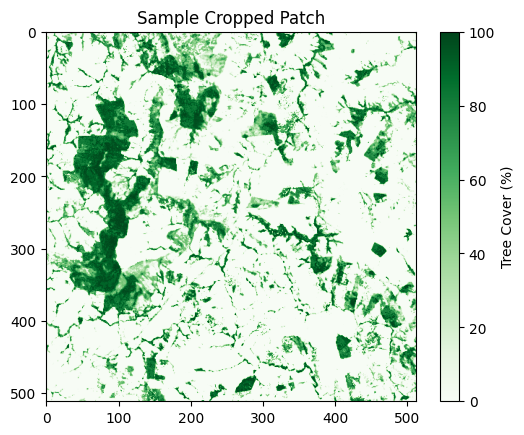

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

tif_path = "/kaggle/input/treecover/treecover/Hansen_GFC2013_treecover2000_00N_050W.tif"

# Function to crop image into patches
def crop_image(tif_path, patch_size=512, num_patches=10):
    with rasterio.open(tif_path) as dataset:
        h, w = dataset.height, dataset.width
        patches = []
        
        for _ in range(num_patches):
            # Random crop coordinates
            x = np.random.randint(0, w - patch_size)
            y = np.random.randint(0, h - patch_size)

            # Read patch
            window = rasterio.windows.Window(x, y, patch_size, patch_size)
            patch = dataset.read(1, window=window)

            # Store patch
            patches.append(patch)

    return patches

# Get cropped patches
patches = crop_image(tif_path)

# Visualize a sample patch
plt.imshow(patches[0], cmap="Greens")
plt.title("Sample Cropped Patch")
plt.colorbar(label="Tree Cover (%)")
plt.show()

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


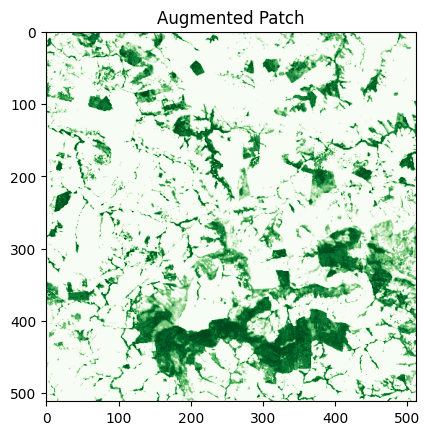

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.simplefilter("ignore")

# Define augmentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

# Apply augmentations
augmented_patch = transform(image=patches[0])["image"]

# Visualize augmented patch
plt.imshow(augmented_patch.permute(1, 2, 0), cmap="Greens")
plt.title("Augmented Patch")
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class ForestCoverDataset(Dataset):
    def __init__(self, tif_path, num_patches=100, patch_size=256, transform=None):
        self.tif_path = tif_path
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.transform = transform
        self.patches, self.labels = self._extract_patches()

    def _extract_patches(self):
        with rasterio.open(self.tif_path) as dataset:
            h, w = dataset.height, dataset.width
            patches, labels = [], []

            for _ in range(self.num_patches):
                x = np.random.randint(0, w - self.patch_size)
                y = np.random.randint(0, h - self.patch_size)

                window = rasterio.windows.Window(x, y, self.patch_size, self.patch_size)
                patch = dataset.read(1, window=window)

                # Normalize (0-1) & Convert to 3-channel (for CNN)
                patch = np.expand_dims(patch, axis=-1)  # Add channel
                patch = np.repeat(patch, 3, axis=-1)  # Convert to 3-channel
                patch = patch / 100.0  # Normalize (0-1)

                # Compute target: Average tree cover in patch
                label = np.mean(patch) * 100  

                patches.append(patch)
                labels.append(label)

        return np.array(patches, dtype=np.float32), np.array(labels, dtype=np.float32)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch, label = self.patches[idx], self.labels[idx]

        if self.transform:
            patch = self.transform(image=patch)["image"]

        return torch.tensor(patch).permute(2, 0, 1), torch.tensor(label)

# Instantiate dataset
dataset = ForestCoverDataset(tif_path="/kaggle/input/treecover/treecover/Hansen_GFC2013_treecover2000_00N_050W.tif")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"✅ Dataset loaded with {len(dataset)} patches!")

✅ Dataset loaded with 100 patches!


Using device: cuda
Dataset created: 350 training, 75 validation, 75 test samples
Training model...
Epoch 1/10, Train Loss: 0.2281, Val Loss: 0.1941, Val IoU: 0.7467, Val F1: 0.9483
✅ New best model saved with F1 score: 0.9483
Epoch 2/10, Train Loss: 0.1351, Val Loss: 0.1082, Val IoU: 0.7802, Val F1: 0.9700
✅ New best model saved with F1 score: 0.9700
Epoch 3/10, Train Loss: 0.1173, Val Loss: 0.0618, Val IoU: 0.8281, Val F1: 0.9816
✅ New best model saved with F1 score: 0.9816
Epoch 4/10, Train Loss: 0.0879, Val Loss: 0.0556, Val IoU: 0.8325, Val F1: 0.9826
✅ New best model saved with F1 score: 0.9826
Epoch 5/10, Train Loss: 0.0629, Val Loss: 0.0441, Val IoU: 0.8477, Val F1: 0.9879
✅ New best model saved with F1 score: 0.9879


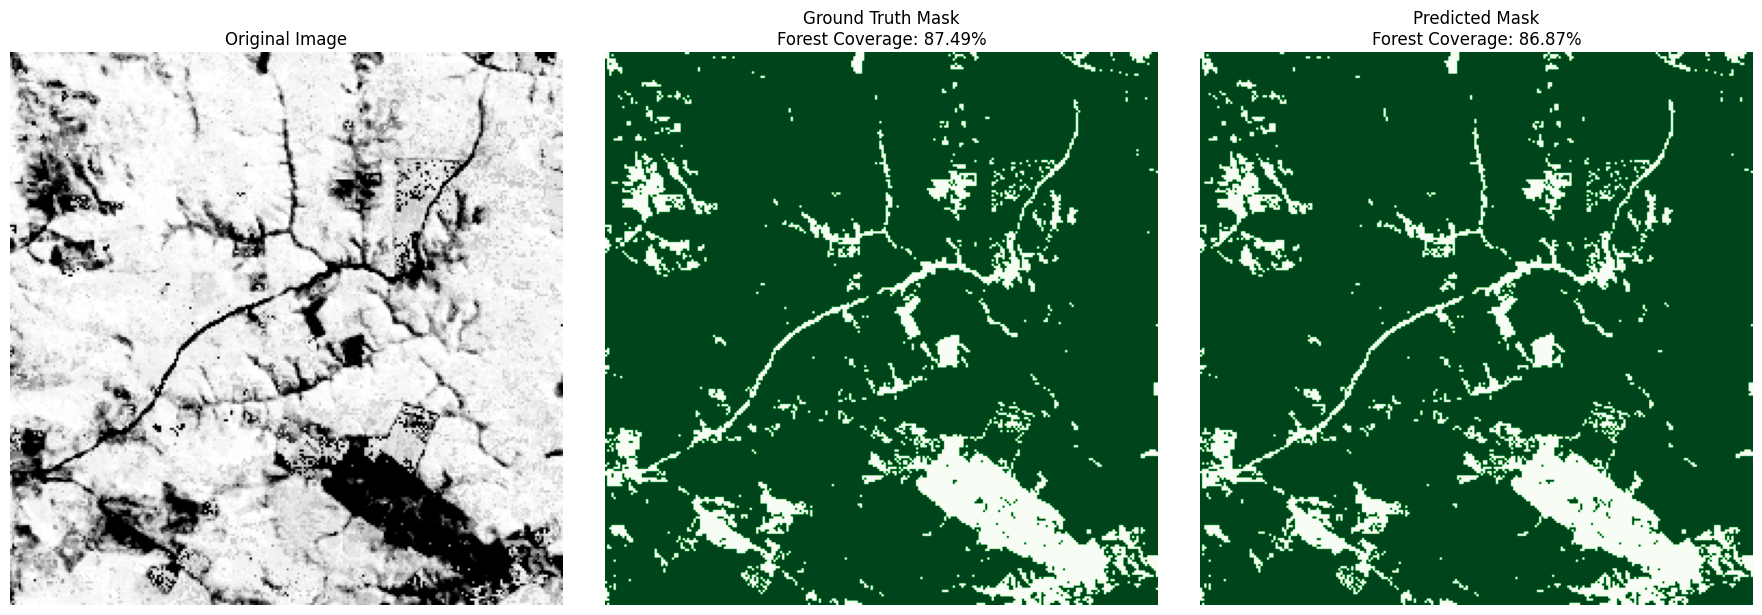

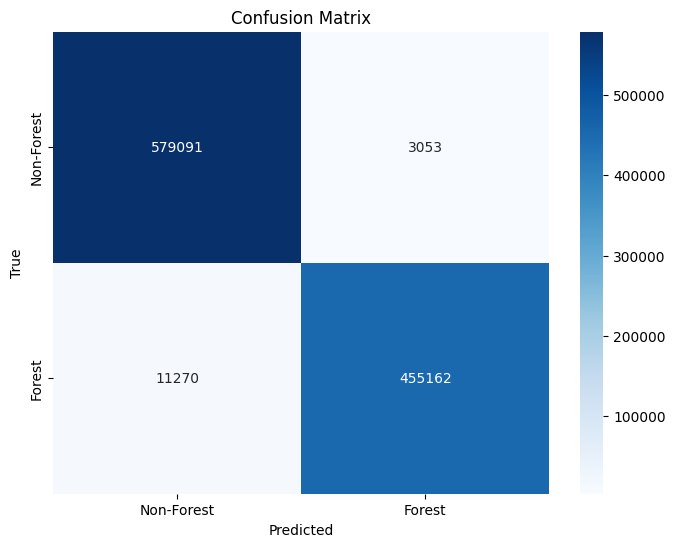

F1 Score: 0.9845
Precision: 0.9933
Recall: 0.9758
Epoch 6/10, Train Loss: 0.0658, Val Loss: 0.0647, Val IoU: 0.7853, Val F1: 0.9694
Epoch 7/10, Train Loss: 0.0662, Val Loss: 0.0610, Val IoU: 0.8258, Val F1: 0.9812
Epoch 8/10, Train Loss: 0.0609, Val Loss: 0.0426, Val IoU: 0.8439, Val F1: 0.9876
Epoch 9/10, Train Loss: 0.0618, Val Loss: 0.0672, Val IoU: 0.8222, Val F1: 0.9774
Epoch 10/10, Train Loss: 0.0549, Val Loss: 0.0369, Val IoU: 0.8442, Val F1: 0.9875


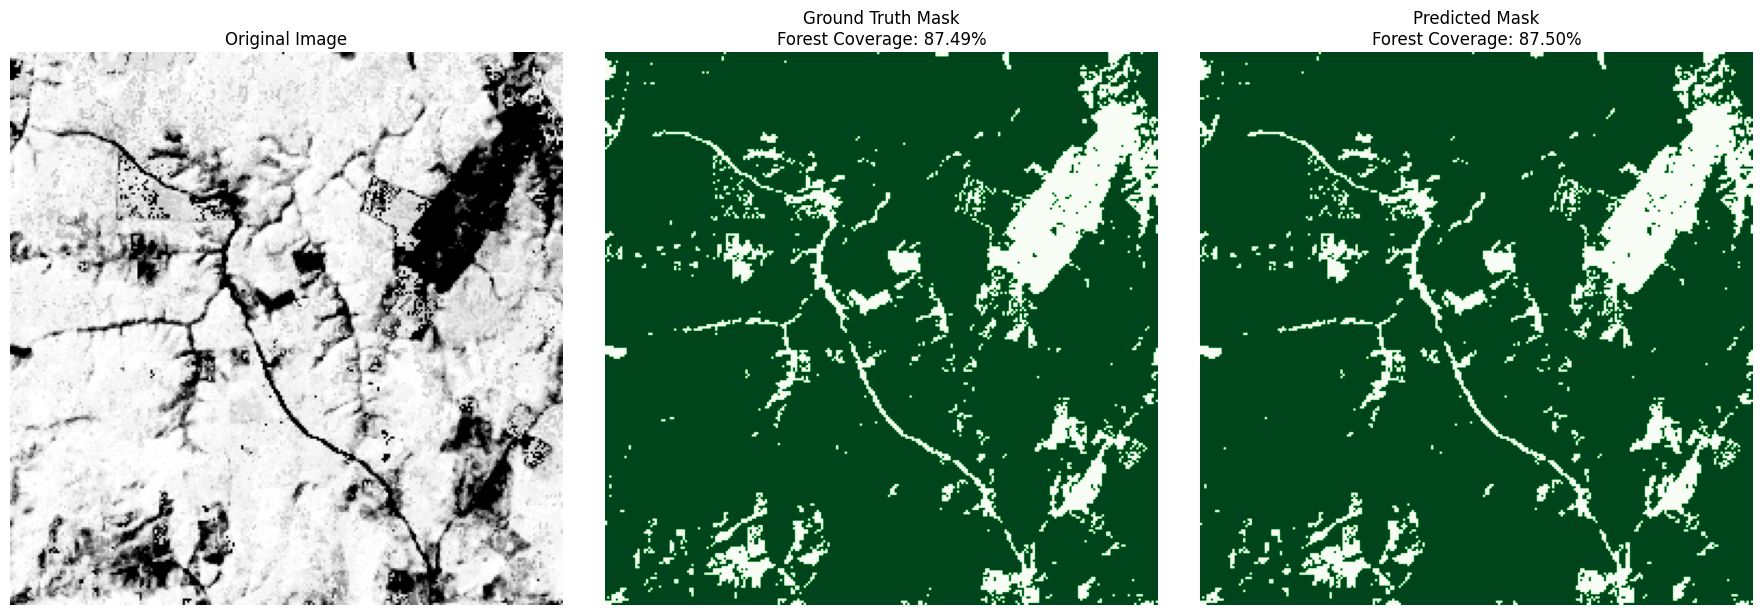

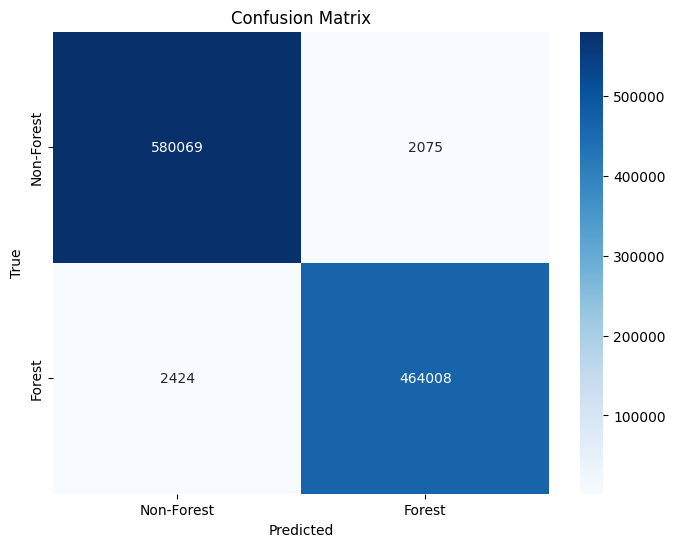

F1 Score: 0.9952
Precision: 0.9955
Recall: 0.9948


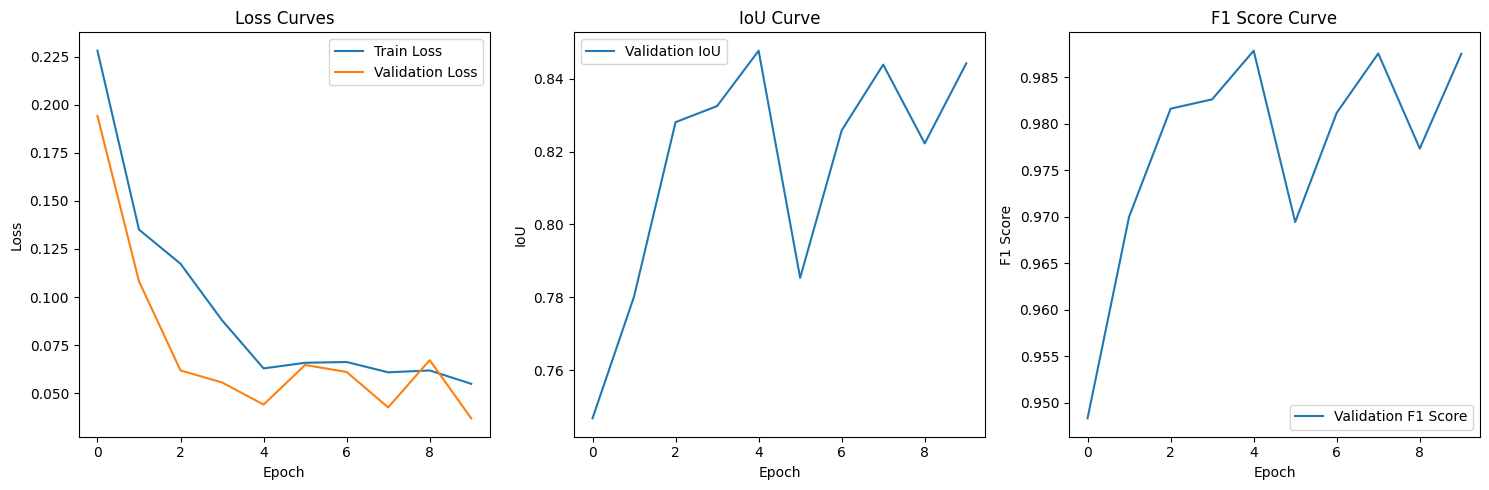

Evaluating model...


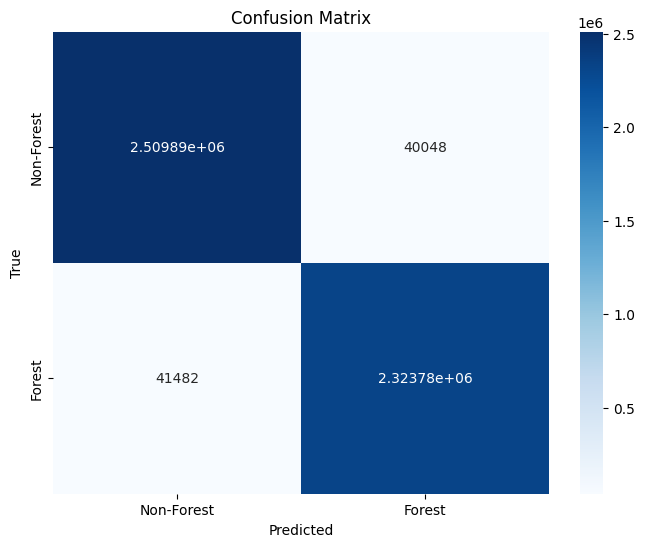

F1 Score: 0.9828
Precision: 0.9831
Recall: 0.9825
Test IoU: 0.7894
Test Accuracy: 0.9839
Test F1 Score: 0.9828
Forest Coverage Error: 1.90%


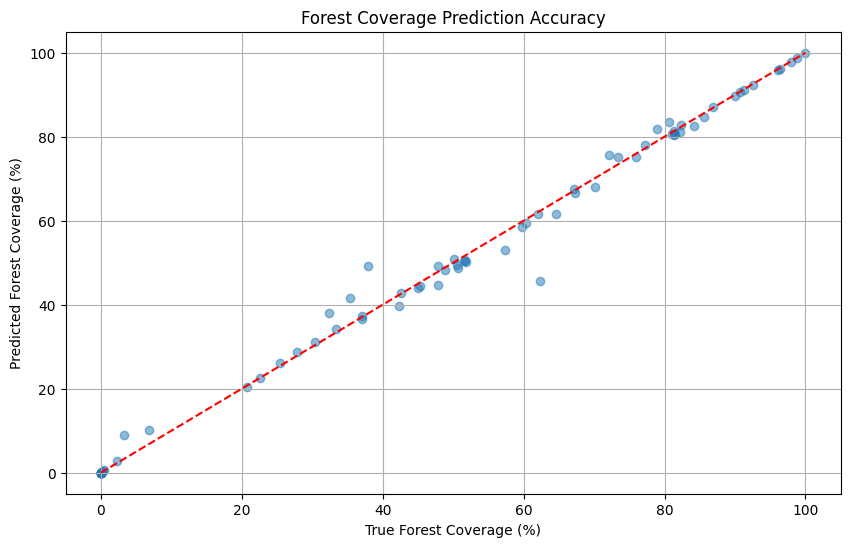

Generating full forest coverage map for /kaggle/input/treecover/treecover/Hansen_GFC2013_treecover2000_00N_050W.tif...


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

# Define U-Net model for segmentation
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.3)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Final output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        bottleneck = self.dropout(bottleneck)
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Final output
        output = self.final_conv(dec1)
        return torch.sigmoid(output)  # Sigmoid for binary segmentation

# Improved dataset class for segmentation
class ForestSegmentationDataset(Dataset):
    def __init__(self, tif_path, num_patches=100, patch_size=256, transform=None, threshold=30):
        self.tif_path = tif_path
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.transform = transform
        self.threshold = threshold  # Tree cover % threshold for forest classification
        self.patches, self.masks = self._extract_patches()
        
    def _extract_patches(self):
        with rasterio.open(self.tif_path) as dataset:
            h, w = dataset.height, dataset.width
            patches, masks = [], []
            
            for _ in range(self.num_patches):
                # Random crop coordinates
                x = np.random.randint(0, w - self.patch_size)
                y = np.random.randint(0, h - self.patch_size)
                
                # Read patch
                window = Window(x, y, self.patch_size, self.patch_size)
                patch = dataset.read(1, window=window)
                
                # Ensure valid values
                patch = np.where(patch > 100, 0, patch)
                
                # Create binary mask (1 for forest, 0 for non-forest)
                mask = (patch >= self.threshold).astype(np.float32)
                
                # Normalize patch (0-1) & Convert to 3-channel
                patch_norm = patch / 100.0
                patch_rgb = np.stack([patch_norm, patch_norm, patch_norm], axis=2)
                
                patches.append(patch_rgb)
                masks.append(mask)
                
        return np.array(patches, dtype=np.float32), np.array(masks, dtype=np.float32)
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch, mask = self.patches[idx], self.masks[idx]
        
        if self.transform:
            transformed = self.transform(image=patch, mask=mask)
            patch = transformed["image"]
            mask = transformed["mask"]
            
        return patch, mask.unsqueeze(0)  # Add channel dimension to mask

# Function to create data transforms
def create_transforms():
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ])
    
    val_transform = A.Compose([
        ToTensorV2()
    ])
    
    return train_transform, val_transform

# Function to compute forest coverage percentage from segmentation mask
def compute_forest_coverage(mask):
    """
    Compute forest coverage percentage from a binary segmentation mask
    
    Args:
        mask: Binary mask where 1 represents forest and 0 represents non-forest
        
    Returns:
        Forest coverage percentage
    """
    return 100.0 * torch.mean(mask.float()).item()

# Function to visualize segmentation results
def visualize_segmentation(image, true_mask, pred_mask, threshold=0.5):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Convert tensors to numpy arrays if needed
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
    if isinstance(true_mask, torch.Tensor):
        true_mask = true_mask.squeeze().cpu().numpy()
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = (pred_mask.squeeze() > threshold).float().cpu().numpy()
    
    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Plot ground truth mask
    axes[1].imshow(true_mask, cmap='Greens')
    axes[1].set_title(f"Ground Truth Mask\nForest Coverage: {100*true_mask.mean():.2f}%")
    axes[1].axis('off')
    
    # Plot predicted mask
    axes[2].imshow(pred_mask, cmap='Greens')
    axes[2].set_title(f"Predicted Mask\nForest Coverage: {100*pred_mask.mean():.2f}%")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to calculate and display confusion matrix and metrics
def calculate_metrics(true_masks, pred_masks, threshold=0.5):
    """
    Calculate and display confusion matrix, F1 score, precision, and recall
    
    Args:
        true_masks: Ground truth masks
        pred_masks: Predicted masks (probabilities)
        threshold: Threshold for binary classification
        
    Returns:
        Dictionary of metrics
    """
    # Convert tensors to numpy arrays
    if isinstance(true_masks, torch.Tensor):
        true_masks = true_masks.cpu().numpy()
    if isinstance(pred_masks, torch.Tensor):
        pred_masks = (pred_masks > threshold).float().cpu().numpy()
    
    # Flatten masks for metric calculation
    true_flat = true_masks.flatten()
    pred_flat = pred_masks.flatten()
    
    # Calculate metrics
    cm = confusion_matrix(true_flat, pred_flat)
    f1 = f1_score(true_flat, pred_flat)
    precision = precision_score(true_flat, pred_flat)
    recall = recall_score(true_flat, pred_flat)
    
    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Non-Forest', 'Forest'],
                yticklabels=['Non-Forest', 'Forest'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print metrics
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return {
        'confusion_matrix': cm,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

# Function to train the model
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001, device='cuda', save_dir='models'):
    # Create directory for saving models
    os.makedirs(save_dir, exist_ok=True)
    
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Metrics tracking
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    best_val_f1 = 0.0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        
        all_true_masks = []
        all_pred_masks = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                
                # Calculate IoU
                pred_masks = (outputs > 0.5).float()
                intersection = (pred_masks * masks).sum((1, 2, 3))
                union = pred_masks.sum((1, 2, 3)) + masks.sum((1, 2, 3)) - intersection
                iou = (intersection / (union + 1e-6)).mean()
                val_iou += iou.item()
                
                # Store masks for metric calculation
                all_true_masks.append(masks.cpu())
                all_pred_masks.append(outputs.cpu())
        
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_iou)
        
        # Concatenate all masks
        all_true_masks = torch.cat(all_true_masks)
        all_pred_masks = torch.cat(all_pred_masks)
        
        # Calculate F1 score
        true_flat = all_true_masks.view(-1).numpy()
        pred_flat = (all_pred_masks.view(-1) > 0.5).float().numpy()
        epoch_f1 = f1_score(true_flat, pred_flat)
        val_f1_scores.append(epoch_f1)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val F1: {epoch_f1:.4f}')
        
        # Save the model if it's the best so far
        if epoch_f1 > best_val_f1:
            best_val_f1 = epoch_f1
            torch.save(model.state_dict(), f"{save_dir}/best_model.pth")
            print(f"✅ New best model saved with F1 score: {epoch_f1:.4f}")
        
        # Always save the latest model
        torch.save(model.state_dict(), f"{save_dir}/latest_model.pth")
        
        # Save model checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_iou': val_iou,
            'val_f1': epoch_f1
        }, f"{save_dir}/checkpoint_epoch_{epoch+1}.pth")
        
        # Visualize sample prediction and metrics
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                # Visualize first image in batch
                visualize_segmentation(
                    images[0].cpu(), 
                    masks[0].cpu(), 
                    outputs[0].cpu()
                )
                
                # Calculate and display metrics
                metrics = calculate_metrics(
                    masks.cpu(),
                    outputs.cpu()
                )
                
                break
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label='Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('IoU Curve')
    
    plt.subplot(1, 3, 3)
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('F1 Score Curve')
    
    plt.tight_layout()
    plt.show()
    
    # Load the best model for return
    model.load_state_dict(torch.load(f"{save_dir}/best_model.pth"))
    
    return model, train_losses, val_losses, val_accuracies, val_f1_scores

# Function to evaluate model on test data
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    test_iou = 0.0
    test_accuracy = 0.0
    forest_coverage_error = 0.0
    
    all_true_masks = []
    all_pred_masks = []
    all_true_coverages = []
    all_pred_coverages = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            # Calculate IoU
            intersection = (pred_masks * masks).sum((1, 2, 3))
            union = pred_masks.sum((1, 2, 3)) + masks.sum((1, 2, 3)) - intersection
            iou = (intersection / (union + 1e-6)).mean()
            test_iou += iou.item()
            
            # Calculate pixel accuracy
            accuracy = (pred_masks == masks).float().mean()
            test_accuracy += accuracy.item()
            
            # Store masks for metric calculation
            all_true_masks.append(masks.cpu())
            all_pred_masks.append(pred_masks.cpu())
            
            # Calculate forest coverage error
            for i in range(len(images)):
                true_coverage = compute_forest_coverage(masks[i])
                pred_coverage = compute_forest_coverage(pred_masks[i])
                all_true_coverages.append(true_coverage)
                all_pred_coverages.append(pred_coverage)
                forest_coverage_error += abs(true_coverage - pred_coverage)
    
    # Calculate averages
    test_iou /= len(test_loader)
    test_accuracy /= len(test_loader)
    forest_coverage_error /= len(test_loader) * len(images)
    
    # Calculate and display metrics on test set
    all_true_masks = torch.cat(all_true_masks)
    all_pred_masks = torch.cat(all_pred_masks)
    
    metrics = calculate_metrics(all_true_masks, all_pred_masks)
    
    return {
        'iou': test_iou,
        'accuracy': test_accuracy,
        'coverage_error': forest_coverage_error,
        'true_coverages': all_true_coverages,
        'pred_coverages': all_pred_coverages,
        'f1_score': metrics['f1_score'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'confusion_matrix': metrics['confusion_matrix']
    }

# Function to predict forest coverage on a full TIF file
def predict_forest_coverage(model, tif_path, patch_size=256, overlap=64, threshold=0.5, device='cuda'):
    model.eval()
    
    with rasterio.open(tif_path) as dataset:
        # Read metadata
        height, width = dataset.height, dataset.width
        
        # Create an empty mask for the predictions
        full_mask = np.zeros((height, width), dtype=np.float32)
        count_mask = np.zeros((height, width), dtype=np.float32)
        
        # Calculate steps
        step_size = patch_size - overlap
        
        # Process in patches
        for y in range(0, height - patch_size + 1, step_size):
            for x in range(0, width - patch_size + 1, step_size):
                # Read patch
                window = Window(x, y, patch_size, patch_size)
                patch = dataset.read(1, window=window)
                
                # Ensure valid values
                patch = np.where(patch > 100, 0, patch)
                
                # Normalize patch (0-1) & Convert to 3-channel
                patch_norm = patch / 100.0
                patch_rgb = np.stack([patch_norm, patch_norm, patch_norm], axis=2)
                
                # Convert to tensor
                patch_tensor = torch.from_numpy(patch_rgb).permute(2, 0, 1).float().unsqueeze(0).to(device)
                
                # Predict
                with torch.no_grad():
                    pred = model(patch_tensor)
                    pred_mask = (pred.squeeze() > threshold).float().cpu().numpy()
                
                # Add to full mask
                full_mask[y:y+patch_size, x:x+patch_size] += pred_mask
                count_mask[y:y+patch_size, x:x+patch_size] += 1
        
        # Average overlapping predictions
        count_mask = np.where(count_mask == 0, 1, count_mask)  # Avoid division by zero
        full_mask = full_mask / count_mask
        
        # Calculate forest coverage percentage
        forest_coverage = 100.0 * np.mean(full_mask)
        
        # Create binary mask
        binary_mask = (full_mask > 0.5).astype(np.uint8)
        
    return full_mask, binary_mask, forest_coverage

# Main execution function
def main(tif_path, num_patches=500, patch_size=256, batch_size=16, epochs=10, forest_threshold=30):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set model save directory
    save_dir = "forest_segmentation_models"
    os.makedirs(save_dir, exist_ok=True)
    
    # Create transforms
    train_transform, val_transform = create_transforms()
    
    # Create dataset
    dataset = ForestSegmentationDataset(
        tif_path=tif_path,
        num_patches=num_patches,
        patch_size=patch_size,
        transform=train_transform,
        threshold=forest_threshold
    )
    
    # Split dataset
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    print(f"Dataset created: {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples")
    
    # Create model
    model = UNet(in_channels=3, out_channels=1)
    
    # Train model
    print("Training model...")
    model, train_losses, val_losses, val_accuracies, val_f1_scores = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        device=device,
        save_dir=save_dir
    )
    
    # Evaluate on test set
    print("Evaluating model...")
    test_results = evaluate_model(model, test_loader, device=device)
    print(f"Test IoU: {test_results['iou']:.4f}")
    print(f"Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"Test F1 Score: {test_results['f1_score']:.4f}")
    print(f"Forest Coverage Error: {test_results['coverage_error']:.2f}%")
    
    # Analyze forest coverage predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(test_results['true_coverages'], test_results['pred_coverages'], alpha=0.5)
    plt.plot([0, 100], [0, 100], 'r--')
    plt.xlabel('True Forest Coverage (%)')
    plt.ylabel('Predicted Forest Coverage (%)')
    plt.title('Forest Coverage Prediction Accuracy')
    plt.grid(True)
    plt.show()
    
    # Generate full prediction for a sample TIF file
    print(f"Generating full forest coverage map for {tif_path}...")
    full_mask, binary_mask, forest_coverage = predict_forest_coverage(
        model=model,
        tif_path=tif_path,
        patch_size=patch_size,
        device=device
    )
    
    print(f"Total Forest Coverage: {forest_coverage:.2f}%")
    
    # Visualize full prediction
    plt.figure(figsize=(12, 12))
    plt.imshow(full_mask, cmap='Greens')
    plt.colorbar(label='Forest Probability')
    plt.title(f'Forest Segmentation Map\nTotal Coverage: {forest_coverage:.2f}%')
    plt.axis('off')
    plt.show()
    
    # Save final prediction
    np.save(f"{save_dir}/full_prediction_mask.npy", full_mask)
    np.save(f"{save_dir}/binary_prediction_mask.npy", binary_mask)
    
    return model, full_mask, binary_mask, forest_coverage

# Example usage
if __name__ == "__main__":
    tif_path = "/kaggle/input/treecover/treecover/Hansen_GFC2013_treecover2000_00N_050W.tif"
    model, full_mask, binary_mask, forest_coverage = main(
        tif_path=tif_path,
        num_patches=500,
        patch_size=256,
        batch_size=16,
        epochs=10,
        forest_threshold=30  # Define forest as ≥30% tree cover
    )
    
    print(f"Total Forest Coverage: {forest_coverage:.2f}%")